# Библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import sys
sys.path.append('../')

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k, evaluete_rec
from src.utils import prefilter_items
from src.recommenders import MainRecommender
from src.myf import reduction_memory

from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

# Данные

In [2]:
data = pd.read_csv('../data/retail_train.csv')
data = reduction_memory(data)

item_features = pd.read_csv('../data/product.csv')
item_features = reduction_memory(item_features)

user_features = pd.read_csv('../data/hh_demographic.csv')

before:		230.09 MB
after:		141.41 MB
reduсed:	88.68 MB
before:		5.17 MB
after:		4.25 MB
reduсed:	0.92 MB


In [3]:
# column processing
# column names in lower case
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

# rename columns
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

# Разбиение на test и train

In [4]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)

val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) & 
                      (data['week_no'] < data['week_no'].max() - val_lvl_2_size_weeks)]

data_train_lvl_2 = data_val_lvl_1.copy() # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_val_lvl_1.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0
2107469,2021,40618753059,594,856060,1,1.77,443,-0.09,101,86,0.0,0.0
2107470,2021,40618753059,594,869344,1,1.67,443,-0.22,101,86,0.0,0.0
2107471,2021,40618753059,594,896862,2,5.00,443,-2.98,101,86,0.0,0.0


# Предподготовка

In [5]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data=data_train_lvl_1,
                                   item_features=item_features)

data_train_lvl_1.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0,1.39
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0,0.82
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0,0.99
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0,1.21
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0,1.50


In [6]:
n_items_after = data_train_lvl_1['item_id'].nunique()
print(f'Decreased # items from {n_items_before} to {n_items_after}')

Decreased # items from 83685 to 5001


# Обучение модели 1го уровня

In [7]:
recommender = MainRecommender(data_train_lvl_1)

In [8]:
recommender.get_als_recommendations(user=2375, N=5)

[899624, 1037863, 923746, 845208, 1082185]

In [9]:
recommender.get_own_recommendations(user=2375, N=5)

[1036501, 1079023, 1085983, 907099, 910439]

In [10]:
recommender.get_similar_items_recommendation(user=2375, N=5)

[868764, 889731, 1055646, 1046545, 981760]

In [11]:
recommender.get_similar_users_recommendation(user=2375, N=5)

[869195, 1015296, 895502, 822677, 1079023]

# Задание 1

### A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?

- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

### B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  

In [12]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns = ['user_id', 'actual']
result_lvl_1 = result_lvl_1[result_lvl_1['user_id'].isin(data_train_lvl_1['user_id'])]
result_lvl_1.head()

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96..."
4,7,"[836281, 843306, 845294, 914190, 920456, 93886..."


In [13]:
K = 20, 50, 100, 200, 500

recall_lvl_1 = pd.DataFrame(columns=['recall@k', 'similar_items', 'als', ' own']).set_index('recall@k')

for k in K:
    
    result_lvl_1['similar_items'] = result_lvl_1['user_id'].apply(
        lambda x: recommender.get_similar_items_recommendation(user=x, N=k)
    )# apply
    
    result_lvl_1['als'] = result_lvl_1['user_id'].apply(
        lambda x: recommender.get_als_recommendations(user=x, N=k)
    )# apply

    result_lvl_1['own'] = result_lvl_1['user_id'].apply(
        lambda x: recommender.get_own_recommendations(user=x, N=k)
    )# apply
    
    recall_lvl_1.loc[k] = evaluete_rec(data=result_lvl_1, true='actual', metric='recall@k', k=k)
    
recall_lvl_1

,similar_items,als,own
recall@k,,,
20,0.030001,0.042017,0.064490
50,0.056768,0.076449,0.104058
100,0.090275,0.117962,0.153365
200,0.142309,0.174486,0.230184
500,0.241823,0.274976,0.342583


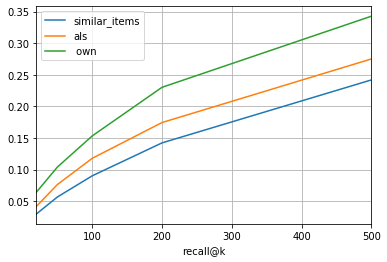

In [14]:
recall_lvl_1.plot()
plt.grid()

##### Дают ли own recommendtions + top-popular лучший recall?

##### ответ:
Тесты показали, что комбинация __own recommendtions + top-popular__ не дает лучший recall

##### ответ:
Видно, что чем больше k тем выше показатель recall@k

### C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

Чем больше k тем больше претедентов будет подобрано, что позволяет модели 2го уровная прогнозировать точнее, но их не должно быть слишком много иначе модель 2го уровная будет работать долго. Думаю можно использовать результат работы own recommendation c k = 200.

# Задание 2.

Обучите модель 2-ого уровня, при этом:

#### - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

In [15]:
class Feature:
    
    def __init__(self, data):
        self.data = data.copy()
    
    # item
    def price(self):
        data = self.data
        
        data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))
        
        return data
    
    # User
    def mean_price_bascet(self):
        data = self.data
        
        sum_price = data.groupby('user_id')['price'].sum()
        unique_baskets = data.groupby('user_id')['basket_id'].nunique()
        
        mean_price = sum_price / unique_baskets
        mean_price.name = 'mean_price_bascet'
        mean_price = mean_price.reset_index()

        data = data.merge(mean_price, on='user_id')
        data.head()
        
        return data
    
    # User Item
    def mean_bascet_diff(self):
        data = self.data
        
        data['mean_bascet_diff'] = data['mean_price_bascet'] - data['price']
        
        return data
    
    # Pipline
    def pipline(self):
        self.data = self.price()
        self.data = self.mean_price_bascet()
        self.data = self.mean_bascet_diff()
        
        return self.data

##### Как корректно вставить эти фичи в трейновые датасеты, Я не понял

# Разбиение на X и y

In [16]:
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=200))

users_lvl_2.head()

,user_id,candidates
0,2070,"[834103, 878302, 1119399, 1085604, 13511722, 9..."
1,2021,"[1119454, 1019142, 871279, 835578, 863762, 101..."
2,1753,"[13842224, 1094371, 1089066, 862981, 901543, 1..."
3,2120,"[480014, 1082185, 6534178, 1029743, 995242, 11..."
4,1346,"[5574377, 480014, 903738, 5568758, 8090560, 91..."


In [17]:
df = pd.DataFrame({'user_id':users_lvl_2['user_id'].values.repeat(len(users_lvl_2['candidates'][0])),
                   'item_id':np.concatenate(users_lvl_2['candidates'].values)})
df.head()

,user_id,item_id
0,2070,834103
1,2070,878302
2,2070,1119399
3,2070,1085604
4,2070,13511722


In [18]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = df.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)

targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
2,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
3,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
4,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [19]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

# Обучение модели 2го уровня (LightGBM)

In [20]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

train_preds = lgb.predict(X_train)
train_preds

array([0., 0., 0., ..., 0., 0., 0.])

In [21]:
def eval_lgbm(targets, preds, k=5):
    targets['recommend'] = preds
    targets = targets[['user_id', 'item_id', 'target', 'recommend']]
    
    target = targets[targets['target'] == 1]
    target = target.groupby('user_id')['item_id'].unique().reset_index()
    target.columns = ['user_id', 'target']
    
    recommend = targets[targets['recommend'] == 1]
    recommend = recommend.groupby('user_id')['item_id'].unique().reset_index()
    recommend.columns = ['user_id', 'recommend']
    
    target_recommend = target.merge(recommend, on='user_id')
    
    result = evaluete_rec(data=target_recommend, true='target', metric='precision@k', k=k)
    
    return result

In [22]:
print(f'precision@5 (train) = {eval_lgbm(targets=targets_lvl_2, preds=train_preds)[0]}')

precision@5 (train) = 0.6163003663003664


#### - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2

# Прогнозирование моделью 1го уровня

In [23]:
train_lvl1 = data[data['week_no'] < data['week_no'].max() - val_lvl_2_size_weeks]
test_lvl1 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

In [24]:
train_lvl1 = prefilter_items(data=train_lvl1,
                             item_features=item_features)

In [25]:
recommender1 = MainRecommender(train_lvl1)

In [26]:
result_lvl1 = test_lvl1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl1.columns = ['user_id', 'actual']

# удаление тех пользователей, на которых модель не обучалась
result_lvl1 = result_lvl1[result_lvl1['user_id'].isin(train_lvl1['user_id'])]
result_lvl1.head()

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412..."


In [27]:
N = 200
# прогнозирование результатов и добавление ление в фрейм

result_lvl1['own'] = result_lvl1['user_id'].apply(
    lambda x: recommender1.get_own_recommendations(user=x, N=N)
)# apply

result_lvl1.head()

,user_id,actual,own
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[856942, 9297615, 5577022, 1074612, 9655212, 8..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[921345, 998206, 1092937, 964594, 864615, 9327..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[13003092, 1119051, 9911484, 8203834, 5569792,..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[845814, 949836, 1075524, 9338009, 1097544, 69..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1116578, 969932, 981660, 1105433, 5577022, 82..."


In [28]:
precisions_lvls = pd.DataFrame(columns=['precision@5', ' own']).set_index('precision@5')

precisions_lvls.loc['level 1'] = evaluete_rec(data=result_lvl1, true='actual', metric='precision@k', k=5)
precisions_lvls

,own
precision@5,
level 1,0.230264


# Прогнозирование моделью 2го уровня

In [29]:
targets_val_lvl_2 = data_val_lvl_2[['user_id', 'item_id']].copy()
targets_val_lvl_2['target'] = 1  # тут только покупки 

targets_val_lvl_2 = df.merge(targets_val_lvl_2, on=['user_id', 'item_id'], how='left')

targets_val_lvl_2['target'].fillna(0, inplace= True)

targets_val_lvl_2 = targets_val_lvl_2.merge(item_features, on='item_id', how='left')
targets_val_lvl_2 = targets_val_lvl_2.merge(user_features, on='user_id', how='left')

targets_val_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
2,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
3,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
4,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [30]:
X_test = targets_val_lvl_2.drop('target', axis=1)
y_test = targets_val_lvl_2[['target']]

X_test[cat_feats] = X_test[cat_feats].astype('category')

In [31]:
test_preds = lgb.predict(X_test)
test_preds

array([0., 0., 0., ..., 0., 0., 0.])

In [32]:
print(f'precision@5 (test) = {eval_lgbm(targets=targets_val_lvl_2, preds=test_preds)[0]}')

precision@5 (test) = 0.45623229461756376


#### - Вырос ли precision@5 при использовании двухуровневой модели?

Видно, что в двухуровневой модели precision вырос почти в 2 раза по сравнению с одноуровневой